# EV Per-Station Forecast 

This notebook forecasts EV charging demand per station and aggregates to city-level.  
We use Prophet for time-series modeling and XGBoost for pooled ML forecasting.


In [2]:
!pip install --upgrade pip
!pip install prophet xgboost pandas scikit-learn matplotlib


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\javid\anaconda3\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import os


In [4]:
# Set paths (adjust if needed)
DATA_DIR = "data"
EV_SESSIONS = os.path.join(DATA_DIR, "ev_sessions.csv")
WEATHER = os.path.join(DATA_DIR, "weather_hourly.csv")

# Load CSVs
df = pd.read_csv(EV_SESSIONS, parse_dates=['start_time'])
weather = pd.read_csv(WEATHER, parse_dates=['ds'])

# Quick check
print("EV sessions shape:", df.shape)
print("Weather shape:", weather.shape)
df.head()


EV sessions shape: (5838, 6)
Weather shape: (1441, 5)


,session_id,start_time,station_id,energy_kwh,duration_minutes,connector_type
0,1,2024-05-01 00:00:00,STN_2,25.48,43,CCS
1,2,2024-05-01 00:00:00,STN_3,26.53,60,CCS
2,3,2024-05-01 01:00:00,STN_1,20.36,42,Type2
3,4,2024-05-01 01:00:00,STN_3,33.05,52,Type2
4,5,2024-05-01 01:00:00,STN_7,18.71,50,CHAdeMO


In [5]:
# Load data
df = pd.read_csv(EV_SESSIONS, parse_dates=['start_time'])
weather = pd.read_csv(WEATHER, parse_dates=['ds'])

# Basic cleaning
df = df.dropna(subset=['start_time'])
df = df[df['energy_kwh'] > 0]
df['ds'] = df['start_time'].dt.floor('h')

# Hourly aggregation per station
hourly_station = df.groupby(['station_id','ds']).agg(
    energy_kwh=('energy_kwh','sum'),
    sessions=('session_id','count')
).reset_index()

# Build continuous hourly index per station
stations = hourly_station['station_id'].unique()
min_ds = hourly_station['ds'].min()
max_ds = hourly_station['ds'].max()
full_idx = pd.date_range(start=min_ds, end=max_ds, freq='h')

frames = []
for st in stations:
    tmp = pd.DataFrame({'ds': full_idx})
    tmp['station_id'] = st
    frames.append(tmp)
full_df = pd.concat(frames, ignore_index=True)
full_df = full_df.merge(hourly_station, on=['station_id','ds'], how='left')
full_df['energy_kwh'] = full_df['energy_kwh'].fillna(0)
full_df['sessions'] = full_df['sessions'].fillna(0)

# Join weather
full_df = full_df.merge(weather, on='ds', how='left')
if 'temperature' in full_df.columns:
   # full_df['temperature'] = full_df['temperature'].fillna(method='ffill').fillna(method='bfill').fillna(full_df['temperature'].mean())
    full_df['temperature'] = full_df['temperature'].ffill() \
                                               .bfill() \
                                               .fillna(full_df['temperature'].mean())
else:
    full_df['temperature'] = full_df.get('temperature', 20.0)
full_df['precipitation'] = full_df['precipitation'].fillna(0)

# Calendar features
full_df['hour'] = full_df['ds'].dt.hour
full_df['dow'] = full_df['ds'].dt.dayofweek

full_df.head()


,ds,station_id,energy_kwh,sessions,temperature,precipitation,humidity,wind_speed,hour,dow
0,2024-05-01 00:00:00,STN_1,0.00,0.0,28.1,1.91,67,3.6,0,2
1,2024-05-01 01:00:00,STN_1,20.36,1.0,26.2,0.48,56,7.6,1,2
2,2024-05-01 02:00:00,STN_1,0.00,0.0,22.5,2.72,48,12.3,2,2
3,2024-05-01 03:00:00,STN_1,32.26,1.0,23.2,2.47,60,5.7,3,2
4,2024-05-01 04:00:00,STN_1,0.00,0.0,23.0,0.42,89,2.0,4,2


## Prophet per-station forecasting (limit to top N busiest stations)
We fit Prophet to the busiest stations (trend + weekly/daily seasonality). Limit N to save time.


In [7]:
# Choose top N busiest stations
N = 5
busiest = hourly_station.groupby('station_id').energy_kwh.sum().nlargest(N).index.tolist()
prophet_forecasts = []

horizon = 48  # hours to predict

for st in busiest:
    sub = full_df[full_df['station_id']==st][['ds','energy_kwh']].rename(columns={'energy_kwh':'y'})
    if len(sub) < 100 or sub['y'].sum() < 1:
        print("Skipping", st, "insufficient data")
        continue
    m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    m.fit(sub)
    future = m.make_future_dataframe(periods=horizon, freq='h')
    fc = m.predict(future)[['ds','yhat']].tail(horizon).copy()
    fc['station_id'] = st
    prophet_forecasts.append(fc)

if prophet_forecasts:
    prophet_all = pd.concat(prophet_forecasts, ignore_index=True)
    prop_agg = prophet_all.groupby('ds').agg(city_yhat=('yhat','sum')).reset_index()
    display(prop_agg.head())
else:
    print("No Prophet forecasts created (check dataset / N)")


17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,city_yhat
0,2024-06-30 01:00:00,44.176986
1,2024-06-30 02:00:00,42.375648
2,2024-06-30 03:00:00,41.354975
3,2024-06-30 04:00:00,41.964986
4,2024-06-30 05:00:00,43.962251


## Pooled XGBoost model (station-le encoded)
We will encode `station_id` and train a pooled model using weather, calendar and session features.


In [9]:
le = LabelEncoder()
full_df['station_le'] = le.fit_transform(full_df['station_id'])

features = ['station_le','hour','dow','temperature','precipitation','sessions']

# Time-aware split: use first 85% of timeline for train
unique_ds = np.sort(full_df['ds'].unique())
cutoff = unique_ds[int(len(unique_ds)*0.85)]
train_mask = full_df['ds'] <= cutoff

X_train = full_df.loc[train_mask, features]
y_train = full_df.loc[train_mask, 'energy_kwh']
X_test = full_df.loc[~train_mask, features]
y_test = full_df.loc[~train_mask, 'energy_kwh']

model = XGBRegressor(n_estimators=300, learning_rate=0.08, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
print("XGBoost pooled MAE:", round(mae,3), "RMSE:", round(rmse,3))


XGBoost pooled MAE: 2.513 RMSE: 4.668


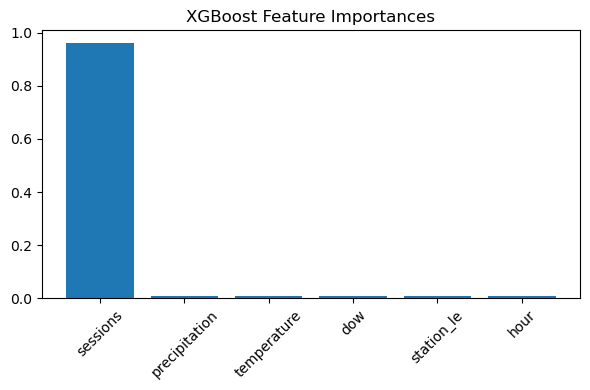

In [10]:
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.bar(range(len(imp)), imp.values)
plt.xticks(range(len(imp)), imp.index, rotation=45)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()


In [11]:
last_ds = hourly_station['ds'].max()
future_index = pd.date_range(start=last_ds + pd.Timedelta(hours=1), periods=48, freq='h')
future_rows = []

for st in hourly_station['station_id'].unique():
    for ds in future_index:
        future_rows.append({'station_id': st, 'ds': ds})

future = pd.DataFrame(future_rows)
future['hour'] = future['ds'].dt.hour
future['dow'] = future['ds'].dt.dayofweek
future['station_le'] = le.transform(future['station_id'])

# Fill weather
hourly_weather = weather.groupby(weather['ds'].dt.hour).agg({'temperature':'mean','precipitation':'mean'}).reset_index().rename(columns={'ds':'hour'})
future = future.merge(hourly_weather, on='hour', how='left')
future['temperature'] = future['temperature'].fillna(hourly_weather['temperature'].mean())
future['precipitation'] = future['precipitation'].fillna(0)
future['sessions'] = 0  # assume average or 0 for simplicity

X_future = future[features]
future['pred_xgb'] = model.predict(X_future)

# Aggregate to city
city_forecast_xgb = future.groupby('ds')['pred_xgb'].sum().reset_index()
city_forecast_xgb.head()


,ds,pred_xgb
0,2024-06-30 01:00:00,1.027321
1,2024-06-30 02:00:00,-0.473980
2,2024-06-30 03:00:00,-0.217572
3,2024-06-30 04:00:00,-0.786296
4,2024-06-30 05:00:00,-1.643192


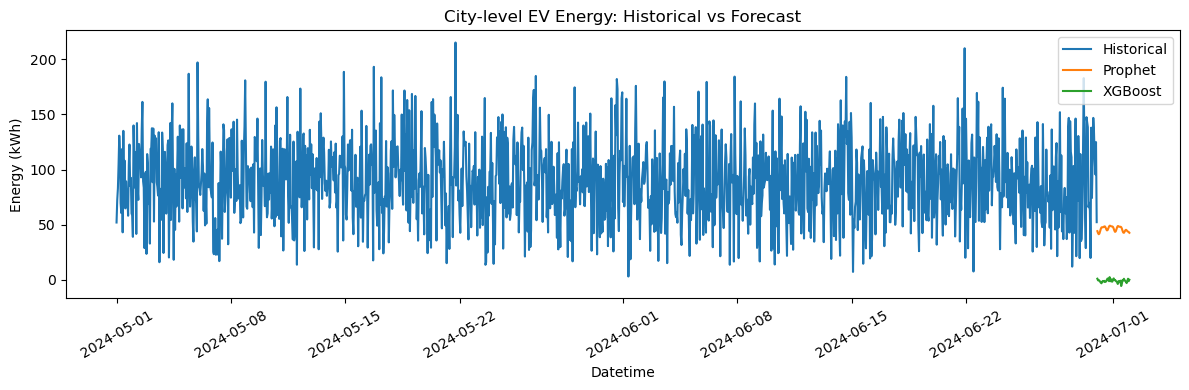

In [12]:
#compare Prophet vs XGBoost vs Historical
city_hist = hourly_station.groupby('ds')['energy_kwh'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(city_hist['ds'], city_hist['energy_kwh'], label='Historical')
plt.plot(prop_agg['ds'], prop_agg['city_yhat'], label='Prophet')
plt.plot(city_forecast_xgb['ds'], city_forecast_xgb['pred_xgb'], label='XGBoost')
plt.title('City-level EV Energy: Historical vs Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [7]:
# --- CREATE CITY-LEVEL FORECAST (XGBoost) ---

from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

# --- Load datasets ---
df = pd.read_csv('data/ev_sessions.csv', parse_dates=['start_time'])
weather = pd.read_csv('data/weather_hourly.csv', parse_dates=['ds'])

# --- Preprocess EV sessions ---
df = df.dropna(subset=['start_time'])
df = df[df['energy_kwh'] > 0]
df['ds'] = df['start_time'].dt.floor('h')
hourly_station = df.groupby(['station_id','ds']).agg(
    energy_kwh=('energy_kwh','sum'),
    sessions=('session_id','count')
).reset_index()

# --- Merge with weather ---
hourly_station = hourly_station.merge(weather, on='ds', how='left')
hourly_station['temperature'] = hourly_station['temperature'].fillna(hourly_station['temperature'].mean())
hourly_station['precipitation'] = hourly_station['precipitation'].fillna(0)
hourly_station['hour'] = hourly_station['ds'].dt.hour
hourly_station['dow'] = hourly_station['ds'].dt.dayofweek

# --- Encode station IDs ---
le = LabelEncoder()
hourly_station['station_le'] = le.fit_transform(hourly_station['station_id'])

# --- Train/Test split ---
features = ['station_le','hour','dow','temperature','precipitation','sessions']
X = hourly_station[features]
y = hourly_station['energy_kwh']
cutoff = int(len(X)*0.85)
X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

# --- Train XGBoost model ---
model = XGBRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# --- Forecast next 48 hours ---
last_ds = hourly_station['ds'].max()
future_index = pd.date_range(start=last_ds + timedelta(hours=1), periods=48, freq='h')

rows = []
for st in hourly_station['station_id'].unique():
    for ds in future_index:
        rows.append({'station_id': st, 'ds': ds})
future = pd.DataFrame(rows)
future['hour'] = future['ds'].dt.hour
future['dow'] = future['ds'].dt.dayofweek
future['station_le'] = le.transform(future['station_id'])
weather['hour'] = weather['ds'].dt.hour
future = future.merge(weather.groupby('hour')[['temperature','precipitation']].mean().reset_index(),
                      on='hour', how='left')
future['sessions'] = hourly_station['sessions'].mean()

X_future = future[features]
future['pred_xgb'] = model.predict(X_future)

# --- Aggregate to city-level ---
city_forecast = future.groupby('ds').agg(city_pred_xgb=('pred_xgb','sum')).reset_index()

# --- Save outputs ---
csv_path = 'data/ev_city_forecast_xgb.csv'
excel_path = 'data/ev_city_forecast_xgb.xlsx'

city_forecast.to_csv(csv_path, index=False)
city_forecast.to_excel(excel_path, index=False)

print(f"✅ Saved CSV: {csv_path}")
print(f"✅ Saved Excel: {excel_path}")

city_forecast.head()


✅ Saved CSV: data/ev_city_forecast_xgb.csv
✅ Saved Excel: data/ev_city_forecast_xgb.xlsx


,ds,city_pred_xgb
0,2024-06-30 01:00:00,230.378006
1,2024-06-30 02:00:00,247.457336
2,2024-06-30 03:00:00,237.218369
3,2024-06-30 04:00:00,224.495026
4,2024-06-30 05:00:00,230.125900


In [5]:
# produce city historical series 
df = pd.read_csv('data/ev_sessions.csv', parse_dates=['start_time'])
df['ds'] = df['start_time'].dt.floor('h')
city_hist = df.groupby('ds').agg(city_energy=('energy_kwh','sum')).reset_index()
city_hist.to_csv('data/ev_city_hist.csv', index=False)
print("Saved:", "data/ev_city_hist.csv")

Saved: data/ev_city_hist.csv


# Heatmap of Hour vs Day of Week

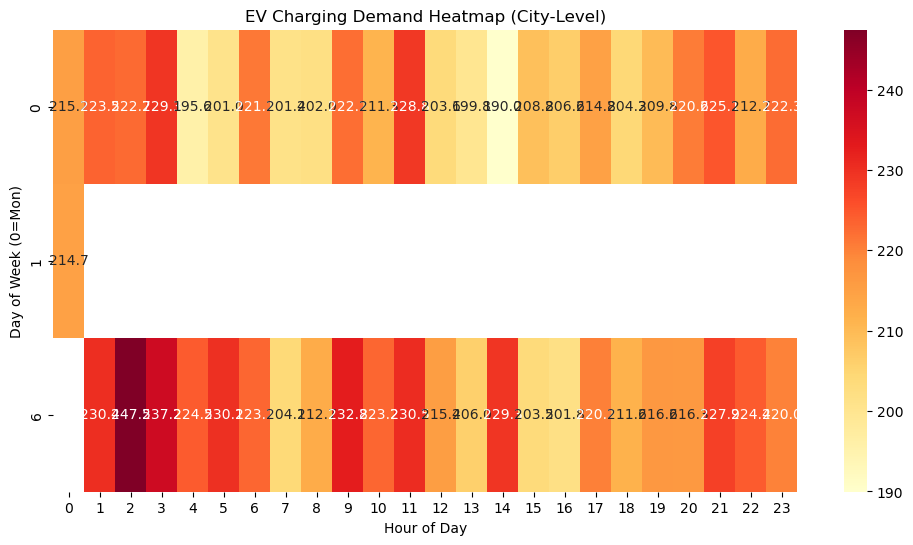

In [16]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load city forecast CSV
city_forecast = pd.read_csv('data/ev_city_forecast_xgb.csv', parse_dates=['ds'])
city_forecast['hour'] = city_forecast['ds'].dt.hour
city_forecast['dow'] = city_forecast['ds'].dt.dayofweek

# Pivot table for heatmap
heatmap_data = city_forecast.pivot_table(index='dow', columns='hour', values='city_pred_xgb')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title("EV Charging Demand Heatmap (City-Level)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon)")
plt.show()


# Forecast Line Chart

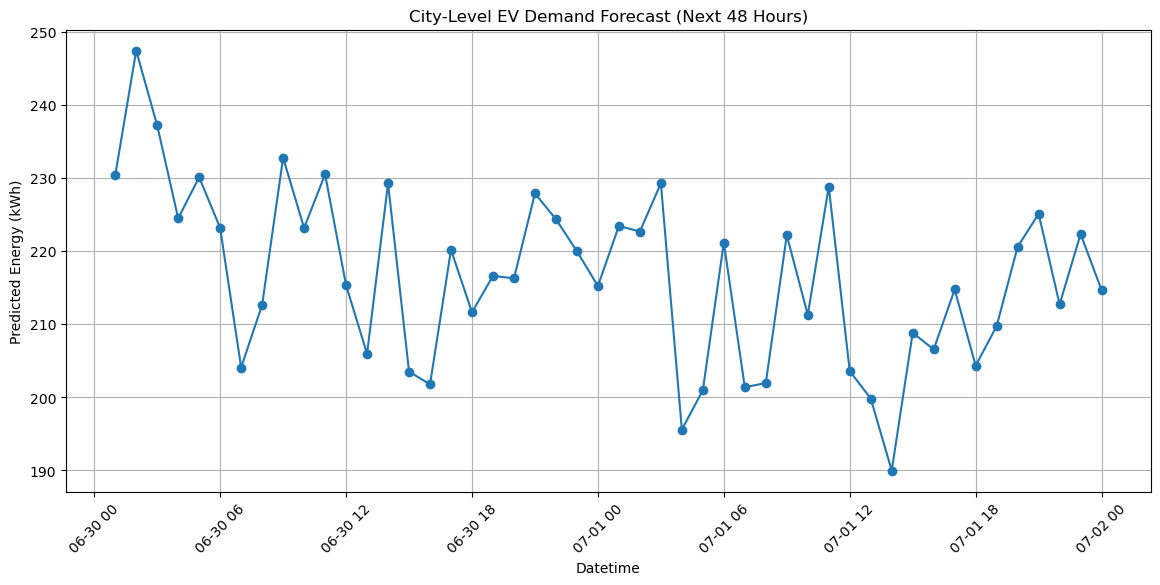

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(city_forecast['ds'], city_forecast['city_pred_xgb'], marker='o')
plt.title("City-Level EV Demand Forecast (Next 48 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Predicted Energy (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
